In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
figure_format = '/cndd2/fangming/projects/miniatlas/results/figures/{}.pdf'

### Gene annot 

In [3]:
f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
print(df_genes.shape)
df_genes.head()


df_genes_v2 = df_genes.groupby('gene_name').first()
print(df_genes_v2.shape)
df_genes_v2.head()

(53379, 8)
(53278, 7)


,gene_id,chr,start,end,strand,gene_type,gid
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,ENSMUSG00000109644
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,ENSMUSG00000108652
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,ENSMUSG00000007777
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,ENSMUSG00000086714
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,ENSMUSG00000043644


### MERFISH 

In [4]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/cell_labels.csv'
df = pd.read_csv(f, index_col=0)
print(df.shape)
df.head()

(241628, 6)


,sampleID,sliceID,pos_x (um),pos_y (um),subclass,final_label
00002e16-356f-419f-b96e-ec7a9327033d,dataset2_sample6,dataset2_slice109,-117.959867,2172.982594,Sst,I30
000068a9-c788-4aa6-becc-175159da9f44,dataset1_sample1,dataset1_slice50,3845.513461,-3839.524502,Endothelial,Endo
0000691f-e1ef-43a9-90c4-82f1ea0c3fde,dataset2_sample3,dataset2_slice139,3472.400334,-3541.783851,L6_IT,E8
00008097-f502-40d1-a486-c61cdd999e7d,dataset2_sample1,dataset2_slice61,-4005.535109,-2639.477937,L2/3_IT,E2
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb,dataset1_sample5,dataset1_slice260,-6387.718623,605.804257,VLMC,VLMC


In [5]:
print(df['sampleID'].unique())
print(df['sliceID'].unique())
print(df['subclass'].unique(), df['subclass'].unique().shape)
print(df['final_label'].unique(), df['final_label'].unique().shape)

['dataset2_sample6' 'dataset1_sample1' 'dataset2_sample3'
 'dataset2_sample1' 'dataset1_sample5' 'dataset1_sample6'
 'dataset1_sample2' 'dataset2_sample2' 'dataset1_sample4'
 'dataset2_sample4' 'dataset1_sample3' 'dataset2_sample5']
['dataset2_slice109' 'dataset1_slice50' 'dataset2_slice139'
 'dataset2_slice61' 'dataset1_slice260' 'dataset1_slice251'
 'dataset1_slice241' 'dataset1_slice313' 'dataset1_slice91'
 'dataset1_slice301' 'dataset2_slice10' 'dataset1_slice71'
 'dataset1_slice102' 'dataset2_slice189' 'dataset1_slice170'
 'dataset2_slice31' 'dataset2_slice79' 'dataset1_slice291'
 'dataset2_slice261' 'dataset1_slice212' 'dataset2_slice309'
 'dataset1_slice122' 'dataset1_slice283' 'dataset1_slice10'
 'dataset2_slice249' 'dataset1_slice200' 'dataset2_slice119'
 'dataset2_slice99' 'dataset2_slice40' 'dataset2_slice70'
 'dataset1_slice31' 'dataset1_slice232' 'dataset1_slice201'
 'dataset2_slice129' 'dataset2_slice319' 'dataset2_slice201'
 'dataset1_slice81' 'dataset2_slice90' 'dataset

In [6]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/merfish_M1.h5ad'
data = h5py.File(f, 'r')
list(data.keys())

['X', 'obs', 'var']

In [7]:
X = data['X'][()]
print(X.shape)
var = data['var'][()]
var = np.array([a[0] for a in data['var'][()]])
print(var.shape)
obs = data['obs'][()]
obs = np.array([a[0] for a in data['obs'][()]])
print(obs.shape)

(241628, 254)
(254,)
(241628,)


In [8]:
assert np.all(obs==df.index.values)

In [9]:
data_mfish = pd.DataFrame(X.T, 
                          index=df_genes_v2.reindex(var)['gid'].values, 
                          columns=obs)
print(data_mfish.shape)
data_mfish.head()

(254, 241628)


,00002e16-356f-419f-b96e-ec7a9327033d,000068a9-c788-4aa6-becc-175159da9f44,0000691f-e1ef-43a9-90c4-82f1ea0c3fde,00008097-f502-40d1-a486-c61cdd999e7d,0000892d-7e0b-4ff4-b445-7ceb69ac8cfb,00012933-4bb8-41e4-93d1-fadbff7b7da3,0001439e-700a-4c9e-ba58-28e57fc1ddd0,00014652-d295-4044-89b0-01db2fc72684,000194b4-e96d-431d-83e1-ea123e1ad6ba,0001b796-672e-45f1-b608-4e8da3bd140f,...,fffe3119-4fe9-4d36-91c4-d2f121c925b6,fffe7413-84d5-431e-baac-13dc98a63a10,fffe9493-a70d-475d-a7cd-7709d9413e74,ffff200c-fc9e-4184-afbf-6907381e260a,ffff37b9-9c6b-4549-990d-229c10dd0609,ffff595e-1e1d-419f-bffe-990f35c11451,ffff99c5-6b32-4cfa-b3d2-fea19f0cb93e,ffffc35c-5472-4f07-a19c-8e05053a80ae,ffffed5e-9068-4a39-be25-201c024e6543,ffffed8d-35a8-4db6-829c-5dded8a29c06
ENSMUSG00000028451,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.823786,0.0,0.000000,0.000000,0.0,0.000000,0.000000
ENSMUSG00000036027,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.988327,...,0.0,0.730213,0.0,0.000000,0.0,0.502365,0.000000,0.0,0.000000,1.261721
ENSMUSG00000085129,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
ENSMUSG00000032985,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.502365,0.000000,0.0,0.000000,0.630861
ENSMUSG00000035783,0.0,1.738648,0.0,0.0,0.0,1.071788,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,1.647572,0.0,0.000000,0.927323,0.0,2.204081,0.630861


In [10]:
cells = df[df['subclass'].fillna('').str.contains(r'^L5_PT')].index
df = df.reindex(cells)
data_mfish = data_mfish[cells.values]

In [11]:
# data_mfish_2 = pd.DataFrame(X.T, 
#                           index=var, 
#                           columns=obs)
# print(data_mfish_2.shape)
# data_mfish_2.head()

In [12]:
# sample_n = 1000
# df_plot = df.join(data_mfish_2.loc['Cux2'].to_frame('Cux2'))

# fig, ax = plt.subplots(figsize=(8,6))
# tx, ty, tc = 'pos_x (um)', 'pos_y (um)', 'Cux2'
# snmcseq_utils.plot_tsne_values_ax(df_plot[df_plot['sliceID']=='dataset1_slice50'], ax, 
#                     tx, ty, tc, 
# #                     sample_n=sample_n,
# #                     legend_mode=1,
#                    )
# ax.set_aspect('equal')
# ax.grid('off')
# plt.show()

# Read in RS2

In [16]:
f = '/cndd2/fangming/projects/miniatlas/rs2/cell_2111_MOp.hdf5'
data = h5py.File(f, 'r')
list(data.keys())

['genes', 'meta', 'rate_gene_ch']

In [17]:
genes = data['genes'][()]
genes = pd.DataFrame(genes, columns=['chr', 'start', 'end', 'strand', 'gene_id', 'gene_name'])
print(genes.shape)
genes.head()

(12261, 6)


,chr,start,end,strand,gene_id,gene_name
0,chr1,3205900,3671498,-1,ENSMUSG00000051951,Xkr4
1,chr1,3466586,3513553,1,ENSMUSG00000089699,Gm1992
2,chr1,3905738,3986215,-1,ENSMUSG00000102343,Gm37381
3,chr1,3999556,4409241,-1,ENSMUSG00000025900,Rp1
4,chr1,4292980,4409187,-1,ENSMUSG00000109048,Rp1


In [18]:
meta = data['meta'][()]
meta = pd.DataFrame(meta[1:, :], columns=meta[0, :]).astype({
    'mCCC': np.float, 
    'mCH': np.float, 
    'mCG': np.float, 
    '# Non-clonal reads': np.int, 
})
print(meta.shape)
meta.head()

(2111, 10)


,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type
0,0.006500,0.032027,0.775850,1090870,Tm3C,MOp,3C,SC,male,L5-ET
1,0.006709,0.034091,0.775146,1458065,Tf3C,MOp,3C,SC,female,L5-ET
2,0.007131,0.035900,0.775895,1614993,Tm4B,MOp,4B,SC,male,L5-ET
3,0.006032,0.028591,0.773345,1598778,Tf4B,MOp,4B,SC,female,L5-ET
4,0.005007,0.022022,0.773471,762007,Pm3C,MOp,3C,STR,male,L4


In [19]:
f = '/cndd2/fangming/projects/miniatlas/rs2/cell_848_L5ET_MOp_6cluster_res4.0_label.npy'
et_clsts = np.load(f)
print(np.unique(et_clsts).shape, et_clsts.shape)

(6,) (848,)


In [20]:
meta_sub = meta[meta['Major Type']=='L5-ET'].sort_index().copy()
meta_sub['Sub Type'] = et_clsts.astype(str)
meta_sub['Major Type'] = ['L5-ET_'+x for x in et_clsts.astype(str)]
print(meta_sub.shape)
meta_sub.head()


(848, 11)


,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type,Sub Type
0,0.006500,0.032027,0.775850,1090870,Tm3C,MOp,3C,SC,male,L5-ET_0,0
1,0.006709,0.034091,0.775146,1458065,Tf3C,MOp,3C,SC,female,L5-ET_1,1
2,0.007131,0.035900,0.775895,1614993,Tm4B,MOp,4B,SC,male,L5-ET_2,2
3,0.006032,0.028591,0.773345,1598778,Tf4B,MOp,4B,SC,female,L5-ET_3,3
8,0.006356,0.030536,0.789224,1696759,Tf3C,MOp,3C,SC,female,L5-ET_4,4


In [21]:
meta['Sub Type'] = np.nan
meta.update(meta_sub)
meta.head()

,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type,Sub Type
0,0.006500,0.032027,0.775850,1090870.0,Tm3C,MOp,3C,SC,male,L5-ET_0,0
1,0.006709,0.034091,0.775146,1458065.0,Tf3C,MOp,3C,SC,female,L5-ET_1,1
2,0.007131,0.035900,0.775895,1614993.0,Tm4B,MOp,4B,SC,male,L5-ET_2,2
3,0.006032,0.028591,0.773345,1598778.0,Tf4B,MOp,4B,SC,female,L5-ET_3,3
4,0.005007,0.022022,0.773471,762007.0,Pm3C,MOp,3C,STR,male,L4,NaN


In [22]:
nmch = data['rate_gene_ch'][()]
nmch = pd.DataFrame(nmch.T, index=genes['gene_id'], columns=meta.index.values)

print(nmch.shape)
nmch.head()

(12261, 2111)


,0,1,2,3,4,5,6,7,8,9,...,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,0.596484,0.562774,0.973410,0.827507,0.360398,0.394905,0.639581,0.465378,0.802192,0.970619,...,0.698528,0.786778,0.413391,0.853294,0.834699,0.949038,1.016534,0.479156,0.313435,0.844506
ENSMUSG00000089699,0.409485,0.666657,1.105788,0.849973,0.000000,0.593597,0.000000,0.459989,0.957563,1.186581,...,0.271223,0.855781,0.568027,0.806972,0.796711,1.057982,0.584903,0.554740,0.000000,1.005871
ENSMUSG00000102343,0.840626,0.924911,1.172054,0.825084,0.000000,0.763111,0.900269,0.939094,0.987396,0.907598,...,1.161791,0.726675,0.759260,0.830782,0.875541,0.890134,0.788926,1.150925,0.000000,0.766424
ENSMUSG00000025900,1.232800,1.019727,0.865994,0.785467,1.565866,0.638042,0.980718,0.615261,1.052833,0.980608,...,0.926816,0.773509,0.722706,1.106217,1.174742,1.067298,0.997026,0.812896,0.000000,0.852511
ENSMUSG00000109048,1.098876,0.752125,0.463248,0.495499,0.000000,0.393148,1.024092,0.551253,0.859545,0.924681,...,1.013985,0.703422,0.715443,0.876114,0.909458,1.088331,1.006497,0.696407,0.000000,0.748122


In [23]:
cells = meta[meta['Major Type'].str.contains(r'L5-ET')].index
meta = meta.reindex(cells)
nmch = nmch[cells.values]

In [24]:
meta.groupby(['Major Type', 'Target']).size().unstack().fillna(0).astype(int).loc[
    ['L5-ET_0', 'L5-ET_2', 'L5-ET_3', 'L5-ET_4', 'L5-ET_1', 'L5-ET_5', ],
    ['MB', 'MY', 'Pons', 'SC', 'TH', 'ACA', 'SSp', 'STR']
]

Target,MB,MY,Pons,SC,TH,ACA,SSp,STR
Major Type,,,,,,,,
L5-ET_0,69,69,19,66,12,0,2,5
L5-ET_2,20,13,31,38,13,0,2,1
L5-ET_3,10,7,3,11,7,1,2,1
L5-ET_4,18,2,39,34,24,0,1,1
L5-ET_1,30,1,45,63,21,0,2,3
L5-ET_5,27,0,58,51,24,0,1,1


### Correlate 
#### map MERFISH to 56 cell types

In [26]:
print(df.shape)
print(data_mfish.shape)
print(meta.shape)
print(nmch.shape)

(6759, 6)
(254, 6759)
(848, 11)
(12261, 848)


In [31]:
df.index.name = 'cellID'

f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/merfish_metadata.tsv'
df.to_csv(f, sep='\t', header=True, index=True)

df.head()

,sampleID,sliceID,pos_x (um),pos_y (um),subclass,final_label
cellID,,,,,,
00050061-3495-4036-bd28-9f5d08a87e3d,dataset1_sample6,dataset1_slice283,1139.926316,-2856.267012,L5_PT,E27
00158d95-a0e5-48b8-a0c5-53298249e1db,dataset1_sample2,dataset1_slice91,2850.904962,2040.780742,L5_PT,E36
001ccc10-5c9a-42b1-a45e-1a15a16262fc,dataset1_sample2,dataset1_slice81,6401.279669,-3460.432048,L5_PT,E37
0021554b-b9bd-471b-a554-fb191f81b12e,dataset2_sample4,dataset2_slice90,1732.008993,1854.869248,L5_PT,E27
002ffe45-25d4-4b97-b8cd-255c409c75a9,dataset1_sample1,dataset1_slice50,5169.180846,-2901.286849,L5_PT,E27


In [25]:
meta.index = ['epi_retro_'+str(cellid) for cellid in meta.index.values]
meta.index.name = 'cellID'

# f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/epi_retro_metadata.tsv'
# meta.to_csv(f, sep='\t', header=True, index=True)

meta.head()

,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type,Sub Type
cellID,,,,,,,,,,,
epi_retro_0,0.006500,0.032027,0.775850,1090870.0,Tm3C,MOp,3C,SC,male,L5-ET_0,0
epi_retro_1,0.006709,0.034091,0.775146,1458065.0,Tf3C,MOp,3C,SC,female,L5-ET_1,1
epi_retro_2,0.007131,0.035900,0.775895,1614993.0,Tm4B,MOp,4B,SC,male,L5-ET_2,2
epi_retro_3,0.006032,0.028591,0.773345,1598778.0,Tf4B,MOp,4B,SC,female,L5-ET_3,3
epi_retro_8,0.006356,0.030536,0.789224,1696759.0,Tf3C,MOp,3C,SC,female,L5-ET_4,4


In [35]:
gc_matrix = GC_matrix(
    data_mfish.index.values,
    data_mfish.columns.values,
    sparse.coo_matrix(data_mfish.values),
)

In [38]:
print(gc_matrix.gene.shape)
print(gc_matrix.cell.shape)
print(gc_matrix.data.shape)

fgene = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/merfish_hvfeatures.gene'
fcell = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/merfish_hvfeatures.cell'
fdata = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/merfish_hvfeatures.npz'
snmcseq_utils.save_gc_matrix(gc_matrix, fgene, fcell, fdata)

(254,)
(6759,)
(254, 6759)


In [14]:
# nmch.shape
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/epi_retro_hvfeatures.tsv'
nmch.columns = ['epi_retro_'+str(cellid) for cellid in nmch.columns.values]
nmch.to_csv(f, sep='\t', header=True, index=True)
nmch.head()

,epi_retro_0,epi_retro_1,epi_retro_2,epi_retro_3,epi_retro_8,epi_retro_9,epi_retro_13,epi_retro_14,epi_retro_15,epi_retro_19,...,epi_retro_2100,epi_retro_2101,epi_retro_2102,epi_retro_2104,epi_retro_2105,epi_retro_2106,epi_retro_2107,epi_retro_2108,epi_retro_2109,epi_retro_2110
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,0.596484,0.562774,0.973410,0.827507,0.802192,0.970619,0.797812,0.856039,0.864322,0.696917,...,0.809978,0.698528,0.786778,0.853294,0.834699,0.949038,1.016534,0.479156,0.313435,0.844506
ENSMUSG00000089699,0.409485,0.666657,1.105788,0.849973,0.957563,1.186581,0.777964,0.784333,0.945087,0.627333,...,1.248716,0.271223,0.855781,0.806972,0.796711,1.057982,0.584903,0.554740,0.000000,1.005871
ENSMUSG00000102343,0.840626,0.924911,1.172054,0.825084,0.987396,0.907598,1.131584,0.619763,1.103163,1.102519,...,0.849872,1.161791,0.726675,0.830782,0.875541,0.890134,0.788926,1.150925,0.000000,0.766424
ENSMUSG00000025900,1.232800,1.019727,0.865994,0.785467,1.052833,0.980608,1.011709,0.999157,0.922091,1.083347,...,0.841701,0.926816,0.773509,1.106217,1.174742,1.067298,0.997026,0.812896,0.000000,0.852511
ENSMUSG00000109048,1.098876,0.752125,0.463248,0.495499,0.859545,0.924681,1.069738,0.879393,0.800233,1.062494,...,0.464916,1.013985,0.703422,0.876114,0.909458,1.088331,1.006497,0.696407,0.000000,0.748122


In [23]:
common_genes = np.intersect1d(nmch.index.values, data_mfish.index.values)
print(common_genes.shape)

(195,)


In [24]:
X = -nmch
meta_x = meta

X = X.reindex(common_genes)
X = X.T
X['cluster'] = meta_x['Major Type']
X = X.groupby('cluster').mean().T
X = X.fillna(X.mean(axis=1), axis=0)

Y = data_mfish
meta_y = df

Y = Y.reindex(common_genes)
Y = Y.T
Y['cluster'] = meta_y['final_label']
Y = Y.groupby('cluster').mean().T
Y = Y.fillna(Y.mean(axis=1), axis=0)

print(X.shape, meta_x.shape, Y.shape, meta_y.shape)

(195, 6) (848, 11) (195, 5) (6759, 6)


In [48]:
corr = snmcseq_utils.spearman_corrcoef(X.T, Y.T)[:len(X.T), len(X.T):]
corr = pd.DataFrame(corr, index=X.columns, columns=Y.columns)
print(corr.shape)
corr.head()

(6, 5)


cluster,E27,E30,E33,E36,E37
cluster,,,,,
L5-ET_0,0.524275,0.404177,0.486007,0.432331,0.454908
L5-ET_1,0.415998,0.468528,0.465078,0.421748,0.438298
L5-ET_2,0.537515,0.432452,0.527285,0.475687,0.480276
L5-ET_3,0.513141,0.452123,0.520421,0.454521,0.478571
L5-ET_4,0.479296,0.446779,0.532807,0.479119,0.474165


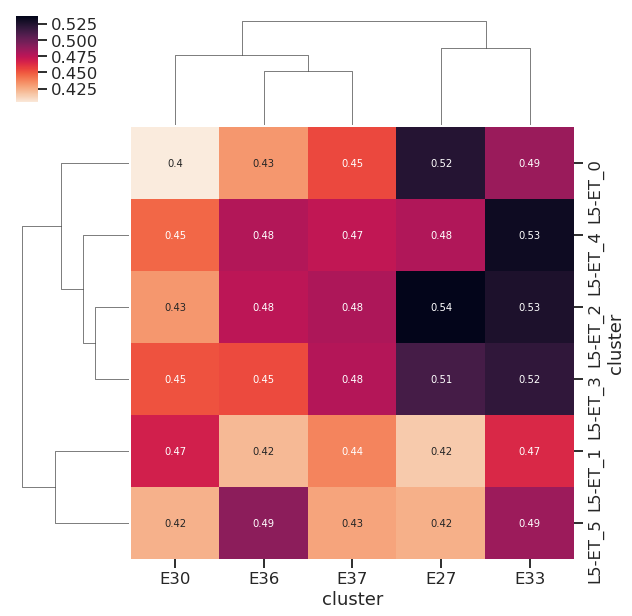

In [53]:
# sns.clustermap(corr.divide(corr.max(axis=1), axis=0), cmap='rocket_r')
sns.clustermap(corr, cmap='rocket_r', annot=True,)

### map at cell level

In [66]:
X = -nmch
meta_x = meta

X = X.reindex(common_genes)
X = X.T
X['cluster'] = meta_x['Major Type']
X = X.groupby('cluster').mean().T
X = X.fillna(X.mean(axis=1), axis=0)

Y = data_mfish
meta_y = df

Y = Y.reindex(common_genes)
# Y = Y.T
# Y['cluster'] = meta_y['final_label']
# Y = Y.groupby('cluster').mean().T
Y = Y.fillna(Y.mean(axis=1), axis=0)

print(X.shape, meta_x.shape, Y.shape, meta_y.shape)

(195, 6) (848, 11) (195, 6759) (6759, 6)


In [67]:
corr = snmcseq_utils.spearman_corrcoef(X.T, Y.T)[:len(X.T), len(X.T):]
corr = pd.DataFrame(corr, index=X.columns, columns=Y.columns)
print(corr.shape)
corr.head()

(6, 6759)


,00050061-3495-4036-bd28-9f5d08a87e3d,00158d95-a0e5-48b8-a0c5-53298249e1db,001ccc10-5c9a-42b1-a45e-1a15a16262fc,0021554b-b9bd-471b-a554-fb191f81b12e,002ffe45-25d4-4b97-b8cd-255c409c75a9,0034d263-8eb2-40ed-9f6a-8913dcbaeadd,003cf527-6195-47dd-8fc9-e5f8b537e4fb,003f815a-1008-4965-b3b6-e64e30ce906e,006356d0-3762-4d49-8eba-0cacbb6c64e9,00705cb2-9374-4a43-8c9c-490b978d3369,...,ffb99d57-3b93-44a0-9e9c-847e18f35713,ffcf85af-fe7c-4205-8ca4-7918ad02346b,ffd7e133-06bf-4bd1-891d-6931cb9c5fd9,ffd829d9-8a11-4233-80d6-4425b04f60bf,ffd9aa3e-d61f-4c6a-b856-2111b160d830,ffdd223c-229b-44bf-80e8-ae5434dfa8ab,ffe32627-f708-4d44-a55a-eb99e2b0e9f4,fff036b1-8489-4136-94e3-0ee75bab6869,fff7f60b-5976-49e9-a0f0-456d9b30cb67,fffb77f8-827e-4c5c-91a4-bb5915ff3b25
cluster,,,,,,,,,,,,,,,,,,,,,
L5-ET_0,0.403684,0.253618,0.376318,0.450469,0.256126,0.345337,0.163411,0.167700,0.457771,0.265986,...,0.297176,0.382414,0.345330,0.227298,0.417932,0.287898,0.257083,0.414791,0.253278,0.352043
L5-ET_1,0.365871,0.299579,0.422616,0.333726,0.171335,0.358235,0.200840,0.239094,0.321993,0.229353,...,0.327413,0.274795,0.433097,0.184229,0.456756,0.353849,0.335264,0.436002,0.287338,0.275936
L5-ET_2,0.419199,0.279585,0.368470,0.450104,0.212326,0.383439,0.166070,0.145492,0.437829,0.268676,...,0.313083,0.392665,0.369768,0.221844,0.453090,0.312221,0.290188,0.451648,0.263798,0.361051
L5-ET_3,0.435778,0.272613,0.387940,0.385598,0.188393,0.343556,0.172228,0.196448,0.400625,0.255096,...,0.325040,0.338397,0.394975,0.240464,0.436369,0.333124,0.278224,0.461263,0.283245,0.327948
L5-ET_4,0.378917,0.346719,0.380450,0.374633,0.155170,0.389063,0.169300,0.160114,0.344034,0.225600,...,0.333122,0.309969,0.450611,0.208534,0.498903,0.319631,0.325165,0.477512,0.292070,0.319355


In [73]:
corr.divide(corr.max(axis=0), axis=1)

,00050061-3495-4036-bd28-9f5d08a87e3d,00158d95-a0e5-48b8-a0c5-53298249e1db,001ccc10-5c9a-42b1-a45e-1a15a16262fc,0021554b-b9bd-471b-a554-fb191f81b12e,002ffe45-25d4-4b97-b8cd-255c409c75a9,0034d263-8eb2-40ed-9f6a-8913dcbaeadd,003cf527-6195-47dd-8fc9-e5f8b537e4fb,003f815a-1008-4965-b3b6-e64e30ce906e,006356d0-3762-4d49-8eba-0cacbb6c64e9,00705cb2-9374-4a43-8c9c-490b978d3369,...,ffb99d57-3b93-44a0-9e9c-847e18f35713,ffcf85af-fe7c-4205-8ca4-7918ad02346b,ffd7e133-06bf-4bd1-891d-6931cb9c5fd9,ffd829d9-8a11-4233-80d6-4425b04f60bf,ffd9aa3e-d61f-4c6a-b856-2111b160d830,ffdd223c-229b-44bf-80e8-ae5434dfa8ab,ffe32627-f708-4d44-a55a-eb99e2b0e9f4,fff036b1-8489-4136-94e3-0ee75bab6869,fff7f60b-5976-49e9-a0f0-456d9b30cb67,fffb77f8-827e-4c5c-91a4-bb5915ff3b25
cluster,,,,,,,,,,,,,,,,,,,,,
L5-ET_0,0.926351,0.731481,0.890449,1.000000,1.000000,0.750131,0.813638,0.701396,1.000000,0.989989,...,0.892092,0.973894,0.766360,0.945248,0.837702,0.813616,0.623595,0.868649,0.867183,0.975050
L5-ET_1,0.839581,0.864041,1.000000,0.740842,0.668946,0.778149,1.000000,1.000000,0.703393,0.853643,...,0.982860,0.699819,0.961132,0.766139,0.915521,1.000000,0.813234,0.913069,0.983798,0.764257
L5-ET_2,0.961955,0.806375,0.871880,0.999192,0.828988,0.832896,0.826877,0.608513,0.956437,1.000000,...,0.939844,1.000000,0.820593,0.922567,0.908174,0.882355,0.703895,0.945836,0.903201,1.000000
L5-ET_3,1.000000,0.786266,0.917949,0.855993,0.735546,0.746264,0.857539,0.821632,0.875164,0.949455,...,0.975738,0.861794,0.876532,1.000000,0.874657,0.941429,0.674877,0.965972,0.969784,0.908315
L5-ET_4,0.869518,1.000000,0.900226,0.831652,0.605834,0.845112,0.842962,0.669670,0.751541,0.839674,...,1.000000,0.789398,1.000000,0.867216,1.000000,0.903298,0.788738,1.000000,1.000000,0.884513
L5-ET_5,0.779097,0.949812,0.737587,0.736861,0.426114,1.000000,0.597452,0.551464,0.670835,0.664392,...,0.929496,0.704275,0.979079,0.686896,0.957855,0.913095,1.000000,0.941525,0.965523,0.732180


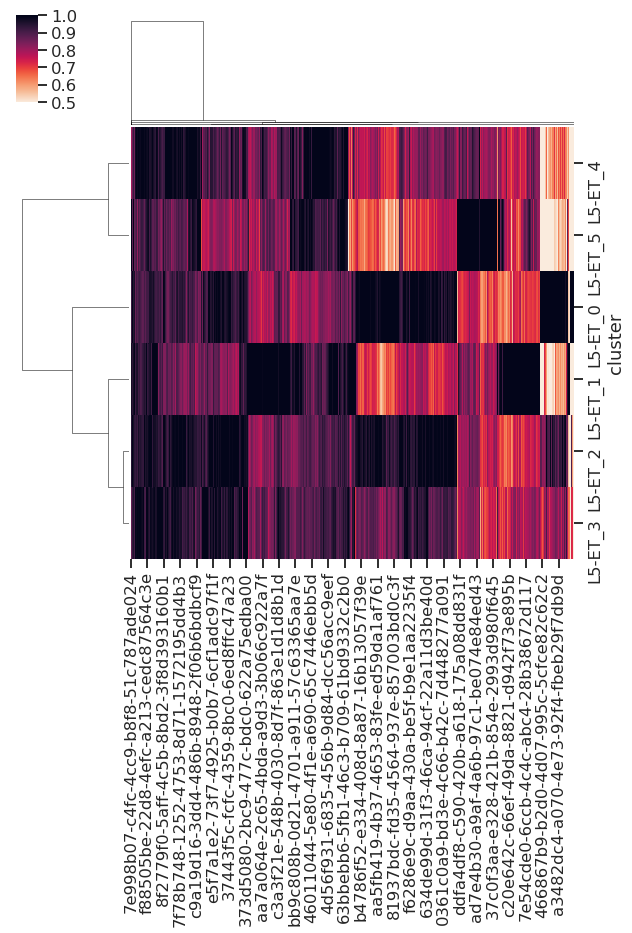

In [74]:
sns.clustermap(corr.divide(corr.max(axis=0), axis=1), cmap='rocket_r', vmax=1, vmin=0.5)
# sns.clustermap(corr, cmap='rocket_r')